In [1]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer

import spacy

import re
import string

Step one: make a simple request to PushShift API

---
Chosen subreddits: r/collapse and r/futurology

In [2]:
pd.read_csv('../data/collapse.csv').columns

/var/folders/pv/cn5ct9b11714cvj2dp8cp0980000gp/T/ipykernel_56179/4121917703.py:1: DtypeWarning: Columns (0,1,8,9,10,11,12,13,17,19,20,21,22,23,24,26,27,29,33,34,35,41,45,49,50,51,59,67,70,72,74,76,78,79,80,81,82,83,87,88,89,90,96,97) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('../data/collapse.csv').columns


Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_is_blocked',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post',
       'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_created_from_ads_ui', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable',
       'is_self', 'is_video', 'link_flair_background_color',
       'link_flair_richtext', 'link_flair_template_id', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'post_hint',
       'preview', 'pwls', 'removed_by_category', 'retrieved_on', 'score',
       'selftext', 'send_replies', 'spoiler', 'stickied', 'subreddit',
       

In [3]:
# will define columns i want in my dataframes - only read in these ones
columns_keep = ['subreddit', 'selftext', 'title', 'author', 'num_comments', 
                'upvote_ratio', 'permalink', 'removed_by_category' ]

In [4]:
collapse = pd.read_csv('../data/collapse.csv', usecols=columns_keep)
collapse = collapse[columns_keep]
print(collapse.shape)

(28741, 8)


/var/folders/pv/cn5ct9b11714cvj2dp8cp0980000gp/T/ipykernel_56179/1513860873.py:1: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  collapse = pd.read_csv('../data/collapse.csv', usecols=columns_keep)


In [5]:
futurology = pd.read_csv('../data/futurology.csv', usecols=columns_keep)
futurology = futurology[columns_keep]
print(futurology.shape)

(28876, 8)


/var/folders/pv/cn5ct9b11714cvj2dp8cp0980000gp/T/ipykernel_56179/3746747698.py:1: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  futurology = pd.read_csv('../data/futurology.csv', usecols=columns_keep)


In [6]:
#view both dfs
collapse.head()

,subreddit,selftext,title,author,num_comments,upvote_ratio,permalink,removed_by_category
0,collapse,[removed],California will be struck with a magnitude 9.9...,DivineSp1rit,0,1.0,/r/collapse/comments/uaum3t/california_will_be...,automod_filtered
1,collapse,[removed],Richard Wolff on Ukraine war's ominous histori...,briancady413,0,1.0,/r/collapse/comments/uau2yw/richard_wolff_on_u...,moderator
2,collapse,[removed],With the current situation with fuel.,baby-converse,0,1.0,/r/collapse/comments/uaq4ge/with_the_current_s...,moderator
3,collapse,[removed],Starvation before Climate Change?,RecordP,0,1.0,/r/collapse/comments/uana4x/starvation_before_...,automod_filtered
4,collapse,[removed],This is evidence of enlightenment just before ...,ShinobiWarrior420,0,1.0,/r/collapse/comments/uamqh1/this_is_evidence_o...,moderator


In [7]:
futurology.head()

,subreddit,selftext,title,author,num_comments,upvote_ratio,permalink,removed_by_category
0,Futurology,[removed],How high is the chance for people under the ag...,Finance_Sweet,0,1.0,/r/Futurology/comments/uaydxt/how_high_is_the_...,reddit
1,Futurology,[removed],Question about neuralink,MatterEnough9656,1,1.0,/r/Futurology/comments/uau91s/question_about_n...,reddit
2,Futurology,[removed],When are we going to stop putting off changing...,UnluckyChemist2162,0,1.0,/r/Futurology/comments/uatn2s/when_are_we_goin...,reddit
3,Futurology,[removed],Elon musk,DigitalArtist1990,1,1.0,/r/Futurology/comments/uajvjd/elon_musk/,moderator
4,Futurology,[removed],Where the world is heading right now ?,idkwhatigottodo,0,1.0,/r/Futurology/comments/uae1az/where_the_world_...,moderator


There are lots of entries where selftext is [removed], but the title is still there.
These entries say they were removed by reddit/moderator/deleted(by user), so that suggests they didn't meet the subreddit's rules. Maybe they violated decency rules, or they are just not relevant to the subreddit. Let's investigate how many there are and what they look like.

In [8]:
selftext_nulls = ['[removed]', '[deleted]']

In [9]:
collapse[(~collapse['removed_by_category'].isnull())]

,subreddit,selftext,title,author,num_comments,upvote_ratio,permalink,removed_by_category
0,collapse,[removed],California will be struck with a magnitude 9.9...,DivineSp1rit,0,1.00,/r/collapse/comments/uaum3t/california_will_be...,automod_filtered
1,collapse,[removed],Richard Wolff on Ukraine war's ominous histori...,briancady413,0,1.00,/r/collapse/comments/uau2yw/richard_wolff_on_u...,moderator
2,collapse,[removed],With the current situation with fuel.,baby-converse,0,1.00,/r/collapse/comments/uaq4ge/with_the_current_s...,moderator
3,collapse,[removed],Starvation before Climate Change?,RecordP,0,1.00,/r/collapse/comments/uana4x/starvation_before_...,automod_filtered
4,collapse,[removed],This is evidence of enlightenment just before ...,ShinobiWarrior420,0,1.00,/r/collapse/comments/uamqh1/this_is_evidence_o...,moderator
...,...,...,...,...,...,...,...,...
15523,collapse,[removed],Is collapse really inevitable?,warp_mode,54,NaN,/r/collapse/comments/e74tnq/is_collapse_really...,reddit
15540,collapse,[removed],The Rules For Your 2020 Holiday Collapse Drink...,CommonEmployment,0,NaN,/r/collapse/comments/e6homu/the_rules_for_your...,moderator
15547,collapse,[removed],Pound surges to two-year high against the euro,elmamounerachidi13,0,NaN,/r/collapse/comments/e6612l/pound_surges_to_tw...,reddit
15564,collapse,[removed],I'm looking for survey participants for our gr...,DisplacementSurvey,0,NaN,/r/collapse/comments/e5pkhp/im_looking_for_sur...,reddit


In [10]:
collapse.drop(index=collapse[(~collapse['removed_by_category'].isnull())].index, inplace=True)
collapse.head(3)

,subreddit,selftext,title,author,num_comments,upvote_ratio,permalink,removed_by_category
21,collapse,"\nShortages surge, for money, for oil, for ele...","Last Week in Collapse: April 16-22, 2022",LastWeekInCollapse,1,1.0,/r/collapse/comments/ua6v6k/last_week_in_colla...,NaN
62,collapse,"Welcome to This Weeg in Collapse, the weegly ...",This Weeg in Collapse (April 2022 - Weeg 3),ThisWeegInCollapse,0,1.0,/r/collapse/comments/u91ks1/this_weeg_in_colla...,NaN
100,collapse,NaN,Decoupling carbon and GDP (exhaustive musings ...,ztycoonz,1,1.0,/r/collapse/comments/u6hgf7/decoupling_carbon_...,NaN


In [11]:
collapse.shape

(21902, 8)

In [12]:
futurology.drop(index=futurology[(~futurology['removed_by_category'].isnull())].index, inplace=True)
print(futurology.shape)
futurology.head(3)

(23512, 8)


,subreddit,selftext,title,author,num_comments,upvote_ratio,permalink,removed_by_category
9,Futurology,What kind of future technology can give a pers...,12th level intellect,pasaaa007,0,1.0,/r/Futurology/comments/ua2za5/12th_level_intel...,NaN
32,Futurology,I’ve been thinking about this for a while as s...,Are children ready for a 4 day school week,Novaz0000,0,1.0,/r/Futurology/comments/u7wvhy/are_children_rea...,NaN
33,Futurology,Do we need to think more about how smartphones...,Teenage gorilla is ‘not addicted’ to smartphon...,Impressive_Tennis724,0,1.0,/r/Futurology/comments/u7vy3s/teenage_gorilla_...,NaN


In [13]:
# look at nulls
collapse[collapse['selftext'].isnull()]

,subreddit,selftext,title,author,num_comments,upvote_ratio,permalink,removed_by_category
100,collapse,NaN,Decoupling carbon and GDP (exhaustive musings ...,ztycoonz,1,1.0,/r/collapse/comments/u6hgf7/decoupling_carbon_...,NaN
1397,collapse,NaN,Let's Talk Collapse,LetsTalkUFOs,0,1.0,/r/collapse/comments/sev8nj/lets_talk_collapse/,NaN
1398,collapse,NaN,Let's Talk Collapse,LetsTalkUFOs,0,1.0,/r/collapse/comments/seu5ui/lets_talk_collapse/,NaN
10441,collapse,NaN,How much of the worlds problems are caused or ...,EmptyDarkness104,5,1.0,/r/collapse/comments/j9y05n/how_much_of_the_wo...,NaN
10483,collapse,NaN,Anyone else suicidal and too pessimistic cause...,EmptyDarkness104,0,1.0,/r/collapse/comments/j7a7c8/anyone_else_suicid...,NaN
...,...,...,...,...,...,...,...,...
28638,collapse,NaN,Apart from Collapse ( obviously ) what's anoth...,borez,8,NaN,/r/collapse/comments/dsdd3/apart_from_collapse...,NaN
28675,collapse,NaN,Does anybody have links to some good e-books o...,mysterion,47,NaN,/r/collapse/comments/d6f0l/does_anybody_have_l...,NaN
28683,collapse,NaN,If you vomit will you still want dinner? Does ...,derekaw,1,NaN,/r/collapse/comments/d14op/if_you_vomit_will_y...,NaN
28688,collapse,NaN,Observation: Recently as the US and World eco...,[deleted],14,NaN,/r/collapse/comments/ctsm5/observation_recentl...,NaN


In [14]:
collapse.dropna(subset=['selftext'], inplace=True)
print(collapse.shape)
collapse.head(3)

(21083, 8)


,subreddit,selftext,title,author,num_comments,upvote_ratio,permalink,removed_by_category
21,collapse,"\nShortages surge, for money, for oil, for ele...","Last Week in Collapse: April 16-22, 2022",LastWeekInCollapse,1,1.0,/r/collapse/comments/ua6v6k/last_week_in_colla...,NaN
62,collapse,"Welcome to This Weeg in Collapse, the weegly ...",This Weeg in Collapse (April 2022 - Weeg 3),ThisWeegInCollapse,0,1.0,/r/collapse/comments/u91ks1/this_weeg_in_colla...,NaN
101,collapse,Not really my idea but here goes.\n\nRight at ...,I have a proposed solution to our economic and...,anthropoz,0,1.0,/r/collapse/comments/u6eqvg/i_have_a_proposed_...,NaN


In [15]:
futurology[futurology['selftext'].isnull()].head()

,subreddit,selftext,title,author,num_comments,upvote_ratio,permalink,removed_by_category
6507,Futurology,NaN,What kind of community-specific custom awards ...,TransPlanetInjection,1,1.0,/r/Futurology/comments/i6nxiu/what_kind_of_com...,NaN
6509,Futurology,NaN,What kind of community-specific custom awards ...,TransPlanetInjection,0,1.0,/r/Futurology/comments/i6nv06/what_kind_of_com...,NaN
6620,Futurology,NaN,How close are we from cybernetic enhancements ...,creaclique,14,1.0,/r/Futurology/comments/hz5sd0/how_close_are_we...,NaN
6874,Futurology,NaN,Really drunk futurist AMA,alchemictech,1,1.0,/r/Futurology/comments/hevw35/really_drunk_fut...,NaN
6967,Futurology,NaN,What year will Amazon ALEXA pass the Turing te...,remotemass,1,1.0,/r/Futurology/comments/h8r61t/what_year_will_a...,NaN


In [16]:
futurology.dropna(subset=['selftext'], inplace=True)
print(futurology.shape)
futurology.head(3)

(21591, 8)


,subreddit,selftext,title,author,num_comments,upvote_ratio,permalink,removed_by_category
9,Futurology,What kind of future technology can give a pers...,12th level intellect,pasaaa007,0,1.0,/r/Futurology/comments/ua2za5/12th_level_intel...,NaN
32,Futurology,I’ve been thinking about this for a while as s...,Are children ready for a 4 day school week,Novaz0000,0,1.0,/r/Futurology/comments/u7wvhy/are_children_rea...,NaN
33,Futurology,Do we need to think more about how smartphones...,Teenage gorilla is ‘not addicted’ to smartphon...,Impressive_Tennis724,0,1.0,/r/Futurology/comments/u7vy3s/teenage_gorilla_...,NaN


In [17]:
#no nulls left
collapse.isnull().sum()[collapse.isnull().sum() > 0]

upvote_ratio           14594
removed_by_category    21083
dtype: int64

In [18]:
futurology.isnull().sum()[futurology.isnull().sum() > 0]

upvote_ratio           19049
removed_by_category    21591
dtype: int64

In [19]:
# change any '[removed]' and '[deleted]' text to empty strings
# will concatenate with the title
collapse.loc[collapse["selftext"].isin(selftext_nulls), "selftext"] = ''

futurology.loc[futurology["selftext"].isin(selftext_nulls), "selftext"] = ''

collapse.shape, futurology.shape

((21083, 8), (21591, 8))

In [20]:
# look at duplicates
collapse[(collapse.duplicated(subset=['title']))]

,subreddit,selftext,title,author,num_comments,upvote_ratio,permalink,removed_by_category
219,collapse,## You MUST include Location: Region when shar...,Weekly Observations: What signs of collapse do...,AutoModerator,2,1.0,/r/collapse/comments/u145h4/weekly_observation...,NaN
335,collapse,## You MUST include Location: Region when shar...,Weekly Observations: What signs of collapse do...,AutoModerator,2,1.0,/r/collapse/comments/tvy9mu/weekly_observation...,NaN
357,collapse,"\nIce shelves continue breaking apart, the new...","Last Week in Collapse: March 26-April 1, 2022",ScruffyTree,1,1.0,/r/collapse/comments/tuhgyz/last_week_in_colla...,NaN
422,collapse,"Society is on track for a collapse, right? Wha...",What will the collapse entail?,Dear-Razzmatazz-9227,0,1.0,/r/collapse/comments/tqh6mw/what_will_the_coll...,NaN
427,collapse,## You MUST include Location: Region when shar...,Weekly Observations: What signs of collapse do...,AutoModerator,2,1.0,/r/collapse/comments/tq5uoc/weekly_observation...,NaN
...,...,...,...,...,...,...,...,...
28532,collapse,When the time comes when the American people r...,"Question To All Police, Military and other Arm...",BinLeenk,0,NaN,/r/collapse/comments/fwirl/question_to_all_pol...,NaN
28549,collapse,Is it easier to just buy a prepared supply or ...,Has anyone made a food for a year kit? I am co...,[deleted],0,NaN,/r/collapse/comments/fozc6/has_anyone_made_a_f...,NaN
28631,collapse,,Where to find one of these self-sufficient sma...,[deleted],0,NaN,/r/collapse/comments/dwzgp/where_to_find_one_o...,NaN
28699,collapse,How many readers here are practicing collapse ...,Practicing Your Skills?,VicinSea,7,NaN,/r/collapse/comments/chv10/practicing_your_ski...,NaN


In [21]:
# a lot of the duplicates are 'Weekly Observations' by author 'AutoModerator'.
# the comments on these posts might be interesting,
# but the title/selftext is not informative, so i'll remove these rows

collapse[collapse.author=='AutoModerator']

,subreddit,selftext,title,author,num_comments,upvote_ratio,permalink,removed_by_category
105,collapse,## You MUST include Location: Region when shar...,Weekly Observations: What signs of collapse do...,AutoModerator,2,1.0,/r/collapse/comments/u69hiv/weekly_observation...,NaN
219,collapse,## You MUST include Location: Region when shar...,Weekly Observations: What signs of collapse do...,AutoModerator,2,1.0,/r/collapse/comments/u145h4/weekly_observation...,NaN
335,collapse,## You MUST include Location: Region when shar...,Weekly Observations: What signs of collapse do...,AutoModerator,2,1.0,/r/collapse/comments/tvy9mu/weekly_observation...,NaN
427,collapse,## You MUST include Location: Region when shar...,Weekly Observations: What signs of collapse do...,AutoModerator,2,1.0,/r/collapse/comments/tq5uoc/weekly_observation...,NaN
524,collapse,## You MUST include Location: Region when shar...,Weekly Observations: What signs of collapse do...,AutoModerator,2,1.0,/r/collapse/comments/tj88v7/weekly_observation...,NaN
...,...,...,...,...,...,...,...,...
17151,collapse,[All previous observations threads are availab...,"Weekly Observations (August 12, 2019): What si...",AutoModerator,289,NaN,/r/collapse/comments/cpayrx/weekly_observation...,NaN
17281,collapse,[All previous observations threads are availab...,"Weekly Observations (August 05, 2019): What si...",AutoModerator,281,NaN,/r/collapse/comments/cm9o0z/weekly_observation...,NaN
17413,collapse,[All previous observations threads are availab...,"Weekly Observations (July 29, 2019): What sign...",AutoModerator,257,NaN,/r/collapse/comments/cj9viv/weekly_observation...,NaN
17508,collapse,[All previous observations threads are availab...,"Weekly Observations (July 22, 2019): What sign...",AutoModerator,290,NaN,/r/collapse/comments/cgbwft/weekly_observation...,NaN


In [22]:
collapse.drop(index=collapse[collapse.author=='AutoModerator'].index, inplace=True)
collapse.shape

(20964, 8)

In [23]:
# any other duplicates?
collapse[(collapse.duplicated(subset=['title']))]
#440 duplicates, drop them
collapse.drop_duplicates(subset='title', inplace=True)
collapse.shape

(20524, 8)

In [24]:
#repeat for futurology
futurology[(futurology.duplicated(subset=['title']))]
#there aren't any weekly/regular automod posts like the ones in collapse, so we'll just drop all duplicates
#601 duplicates, drop them
futurology.drop_duplicates(subset='title', inplace=True)
futurology.shape

(20990, 8)

---
**Cleaning text strings and preprocessing**

In [25]:
#function to clean text
#pattern is borrowed from a tutorial on MonkeyLearn
#https://monkeylearn.com/blog/text-cleaning/

def clean_text(string):
    p = r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"
    try:
        #remove pattern: urls, punctuation, unicode
        string = re.sub(p, ' ', string)
        
        #remove digits - maybe some years are useful to keep, 
        #but it is too complicated to keep only years so i'll get rid of all of them
        string = re.sub(r'\d+', '', string)
        
        #remove whitespace
        string = re.sub('\s+', ' ', string).strip()
    except:
        pass
    
    #lowercase everything and remove 'collapse' and 'futurology'
    string = string.lower()
    string = re.sub('collapse', '', string)
    string = re.sub('futurology', '', string)
    return string

In [26]:
collapse.insert(3, 'clean_self', collapse['selftext'].apply(clean_text))
collapse.insert(4, 'clean_title', collapse['title'].apply(clean_text))

In [27]:
futurology.insert(3, 'clean_self', futurology['selftext'].apply(clean_text))
futurology.insert(4, 'clean_title', futurology['title'].apply(clean_text))

In [28]:
#combine selftext and title into one new (clean) column
collapse.insert(5, 'clean_text', collapse['clean_title']+' '+collapse['clean_self'])
futurology.insert(5, 'clean_text', futurology['clean_title']+' '+futurology['clean_self'])

In [29]:
#check for nulls - only nulls are in upvote_ratio and in removed_by_category (which is all supposed to be null)
collapse.isnull().sum()
futurology.isnull().sum()

subreddit                  0
selftext                   0
title                      0
clean_self                 0
clean_title                0
clean_text                 0
author                     0
num_comments               0
upvote_ratio           18487
permalink                  0
removed_by_category    20990
dtype: int64

In [30]:
collapse[collapse.clean_text.str.contains('lifeboat ethics in the anthropocene ')]

,subreddit,selftext,title,clean_self,clean_title,clean_text,author,num_comments,upvote_ratio,permalink,removed_by_category
17803,collapse,[https://en.wikipedia.org/wiki/Lifeboat\_ethic...,LIFEBOAT ETHICS In The Anthropocene,,lifeboat ethics in the anthropocene,lifeboat ethics in the anthropocene,TyboVEGAN,2,NaN,/r/collapse/comments/c94m55/lifeboat_ethics_in...,NaN


In [31]:
collapse.loc[17803, 'selftext']

'[https://en.wikipedia.org/wiki/Lifeboat\\_ethics](https://en.wikipedia.org/wiki/Lifeboat_ethics)'

---
**EDA**

In [32]:
#combine dataframes
reddit = pd.concat([collapse, futurology])
is_collapse = [1 if (each=='collapse') else 0 for each in reddit.subreddit]
reddit.insert(0, 'is_collapse', is_collapse)
reddit.head()

,is_collapse,subreddit,selftext,title,clean_self,clean_title,clean_text,author,num_comments,upvote_ratio,permalink,removed_by_category
21,1,collapse,"\nShortages surge, for money, for oil, for ele...","Last Week in Collapse: April 16-22, 2022",shortages surge for money for oil for electric...,last week in april,last week in april shortages surge for money ...,LastWeekInCollapse,1,1.0,/r/collapse/comments/ua6v6k/last_week_in_colla...,NaN
62,1,collapse,"Welcome to This Weeg in Collapse, the weegly ...",This Weeg in Collapse (April 2022 - Weeg 3),welcome to this weeg in the weegly report whe...,this weeg in april weeg,this weeg in april weeg welcome to this weeg ...,ThisWeegInCollapse,0,1.0,/r/collapse/comments/u91ks1/this_weeg_in_colla...,NaN
101,1,collapse,Not really my idea but here goes.\n\nRight at ...,I have a proposed solution to our economic and...,not really my idea but here goes right at the ...,i have a proposed solution to our economic and...,i have a proposed solution to our economic and...,anthropoz,0,1.0,/r/collapse/comments/u6eqvg/i_have_a_proposed_...,NaN
120,1,collapse,Russia-Ukraine Conflict Megathread 5\n\nCreate...,Ukraine conflict megathread 5,russia ukraine conflict megathread created on ...,ukraine conflict megathread,ukraine conflict megathread russia ukraine con...,FishDisciple,1,1.0,/r/collapse/comments/u5hyqk/ukraine_conflict_m...,NaN
129,1,collapse,"Political tensions rise with food prices, infl...","Last Week in Collapse: April 9-15, 2022",political tensions rise with food prices infla...,last week in april,last week in april political tensions rise wi...,LastWeekInCollapse,1,1.0,/r/collapse/comments/u4y2bq/last_week_in_colla...,NaN


In [33]:
print(reddit.subreddit.value_counts(), reddit.is_collapse.value_counts())

Futurology    20990
collapse      20524
Name: subreddit, dtype: int64 0    20990
1    20524
Name: is_collapse, dtype: int64


In [34]:
reddit

,is_collapse,subreddit,selftext,title,clean_self,clean_title,clean_text,author,num_comments,upvote_ratio,permalink,removed_by_category
21,1,collapse,"\nShortages surge, for money, for oil, for ele...","Last Week in Collapse: April 16-22, 2022",shortages surge for money for oil for electric...,last week in april,last week in april shortages surge for money ...,LastWeekInCollapse,1,1.0,/r/collapse/comments/ua6v6k/last_week_in_colla...,NaN
62,1,collapse,"Welcome to This Weeg in Collapse, the weegly ...",This Weeg in Collapse (April 2022 - Weeg 3),welcome to this weeg in the weegly report whe...,this weeg in april weeg,this weeg in april weeg welcome to this weeg ...,ThisWeegInCollapse,0,1.0,/r/collapse/comments/u91ks1/this_weeg_in_colla...,NaN
101,1,collapse,Not really my idea but here goes.\n\nRight at ...,I have a proposed solution to our economic and...,not really my idea but here goes right at the ...,i have a proposed solution to our economic and...,i have a proposed solution to our economic and...,anthropoz,0,1.0,/r/collapse/comments/u6eqvg/i_have_a_proposed_...,NaN
120,1,collapse,Russia-Ukraine Conflict Megathread 5\n\nCreate...,Ukraine conflict megathread 5,russia ukraine conflict megathread created on ...,ukraine conflict megathread,ukraine conflict megathread russia ukraine con...,FishDisciple,1,1.0,/r/collapse/comments/u5hyqk/ukraine_conflict_m...,NaN
129,1,collapse,"Political tensions rise with food prices, infl...","Last Week in Collapse: April 9-15, 2022",political tensions rise with food prices infla...,last week in april,last week in april political tensions rise wi...,LastWeekInCollapse,1,1.0,/r/collapse/comments/u4y2bq/last_week_in_colla...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
28871,0,Futurology,"I know, I know that there is a never ending ma...",A future without divisive political parties an...,i know i know that there is a never ending man...,a future without divisive political parties an...,a future without divisive political parties an...,[deleted],11,NaN,/r/Futurology/comments/11s99v/a_future_without...,NaN
28872,0,Futurology,Ive always pondered this. Thoughts?,Do you think humans will ever create a biosynt...,ive always pondered this thoughts,do you think humans will ever create a biosynt...,do you think humans will ever create a biosynt...,Siedrah,21,NaN,/r/Futurology/comments/11s79r/do_you_think_hum...,NaN
28873,0,Futurology,As we approach 200-300-400yrs old it is likely...,"A cure for ageing is inevitable, so how will f...",as we approach yrs old it is likely the super ...,a cure for ageing is inevitable so how will fu...,a cure for ageing is inevitable so how will fu...,maccit,74,NaN,/r/Futurology/comments/11s1kg/a_cure_for_agein...,NaN
28874,0,Futurology,I'm disappointed that the following have not m...,What technologies have you expected to be real...,i m disappointed that the following have not m...,what technologies have you expected to be real...,what technologies have you expected to be real...,drbonerlol,45,NaN,/r/Futurology/comments/11rryg/what_technologie...,NaN


In [35]:
# distribution of word count of titles and posts
reddit['self_words'] = [len(text.split()) for text in reddit['clean_self']]
reddit['title_words'] = [len(text.split()) for text in reddit['clean_title']]
reddit.head()

,is_collapse,subreddit,selftext,title,clean_self,clean_title,clean_text,author,num_comments,upvote_ratio,permalink,removed_by_category,self_words,title_words
21,1,collapse,"\nShortages surge, for money, for oil, for ele...","Last Week in Collapse: April 16-22, 2022",shortages surge for money for oil for electric...,last week in april,last week in april shortages surge for money ...,LastWeekInCollapse,1,1.0,/r/collapse/comments/ua6v6k/last_week_in_colla...,NaN,1315,4
62,1,collapse,"Welcome to This Weeg in Collapse, the weegly ...",This Weeg in Collapse (April 2022 - Weeg 3),welcome to this weeg in the weegly report whe...,this weeg in april weeg,this weeg in april weeg welcome to this weeg ...,ThisWeegInCollapse,0,1.0,/r/collapse/comments/u91ks1/this_weeg_in_colla...,NaN,531,5
101,1,collapse,Not really my idea but here goes.\n\nRight at ...,I have a proposed solution to our economic and...,not really my idea but here goes right at the ...,i have a proposed solution to our economic and...,i have a proposed solution to our economic and...,anthropoz,0,1.0,/r/collapse/comments/u6eqvg/i_have_a_proposed_...,NaN,481,16
120,1,collapse,Russia-Ukraine Conflict Megathread 5\n\nCreate...,Ukraine conflict megathread 5,russia ukraine conflict megathread created on ...,ukraine conflict megathread,ukraine conflict megathread russia ukraine con...,FishDisciple,1,1.0,/r/collapse/comments/u5hyqk/ukraine_conflict_m...,NaN,83,3
129,1,collapse,"Political tensions rise with food prices, infl...","Last Week in Collapse: April 9-15, 2022",political tensions rise with food prices infla...,last week in april,last week in april political tensions rise wi...,LastWeekInCollapse,1,1.0,/r/collapse/comments/u4y2bq/last_week_in_colla...,NaN,1382,4


In [36]:
# identify longest and shortest posts
reddit.sort_values(by='self_words', ascending=True)[['clean_self']][8066:8081]

,clean_self
19134,infrastructure
13582,interview
18494,d
26055,insights
21059,h
21161,enjoy
21228,d
21230,d
21118,g
12259,r


In [37]:
reddit.sort_values(by='self_words', ascending=False)[['clean_self']].head(15)

,clean_self
8519,in to the blue my next decade by antti luode s...
1453,to provide some context as to why i chose that...
7887,this is a paper from peter salonius a canadian...
11977,warning long i originally posted this in r sim...
11196,however these applications are partial in thei...
5463,a few days ago i posted my idea about web four...
10760,on nothing by henry condon i created the world...
1434,as researchers we spend much time and effort i...
7721,the following is a work of fiction any similar...
15325,i m not really that much fucking with you when...


In [38]:
# mean word count length for each subreddit
reddit.groupby(['subreddit']).mean()[['self_words','title_words']]

,self_words,title_words
subreddit,,
Futurology,116.803383,11.538304
collapse,183.583025,11.353050


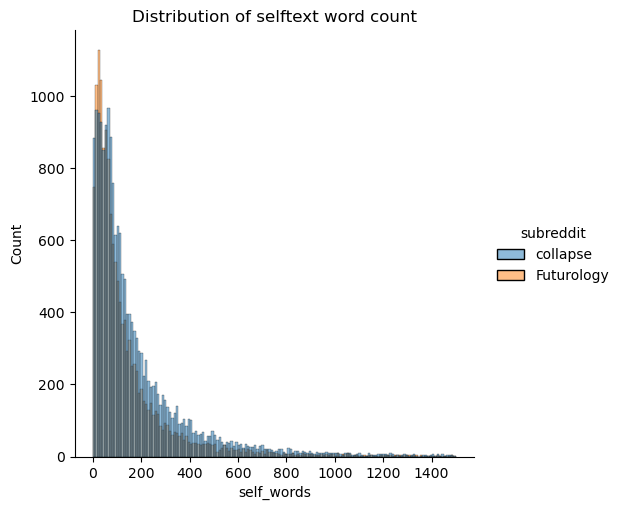

In [39]:
# histogram distribution of post lengths (separate hists or combined)
# cut it at 1500 so histogram is legible
# we can see that collapse has a higher count for the higher-length posts
sns.displot(data=reddit[(reddit.self_words>0)&(reddit.self_words<1500)], 
            x='self_words', hue='subreddit').set(title='Distribution of selftext word count');

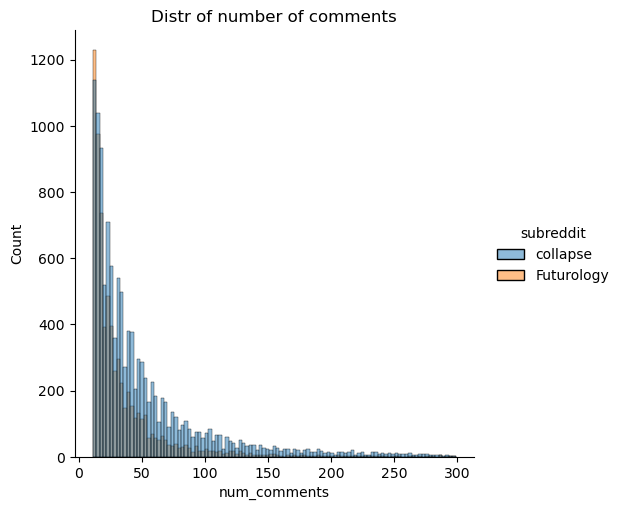

In [40]:
# distribution of upvote_ratio and num_comments
sns.displot(data=reddit[(reddit.num_comments>10) & (reddit.num_comments<300)], x='num_comments', hue='subreddit').set(title='Distr of number of comments');

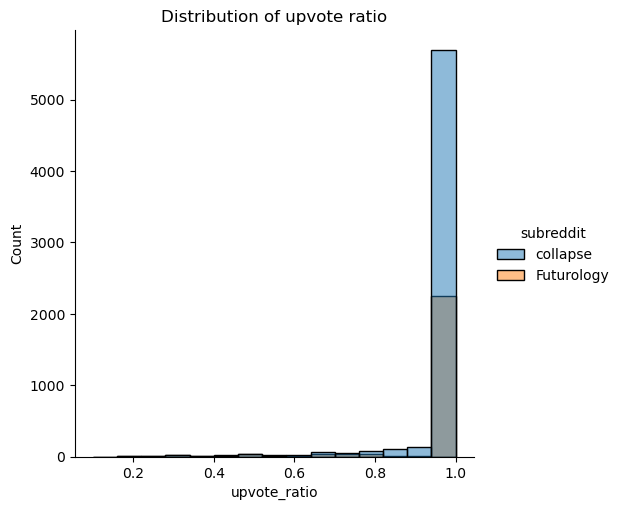

In [41]:
sns.displot(data=reddit[~reddit.upvote_ratio.isnull()], 
            x='upvote_ratio', hue='subreddit').set(title='Distribution of upvote ratio');

In [42]:
# do any users post more than once?
reddit.author.value_counts()

[deleted]           3535
kulmthestatusquo     554
CommonEmployment     333
Hubertus_Hauger      284
Arowx                257
                    ... 
DrCatt                 1
swinebone              1
Sauwan                 1
Rwh909r                1
crazmnky90             1
Name: author, Length: 20453, dtype: int64

In [43]:
# vectorized text
cv = CountVectorizer(stop_words='english')

collapse_cv = cv.fit_transform(collapse['clean_text'])
collapse_cv = pd.DataFrame(collapse_cv.todense(), columns=cv.get_feature_names_out())

In [44]:
collapse_cv.head()

,aa,aaa,aaaa,aaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaagh,aaaaaaaaahem,aaaaargh,aaahhh,aaand,aac,...,zuma,zun,zurek,zurich,zuse,zweig,zygmunt,zyklon,zymunt,zzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
futurology_cv = cv.fit_transform(futurology['clean_text'])
futurology_cv = pd.DataFrame(futurology_cv.todense(), columns=cv.get_feature_names_out())

In [46]:
futurology_cv.head()

,aa,aaa,aaaaaaaaand,aaaaannnnddd,aaah,aab,aadvac,aaicirclejerk,aalqhata,aalto,...,zurich,zurn,zuse,zwecke,zwitterionic,zxap,zyamatin,zygomatic,zygote,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


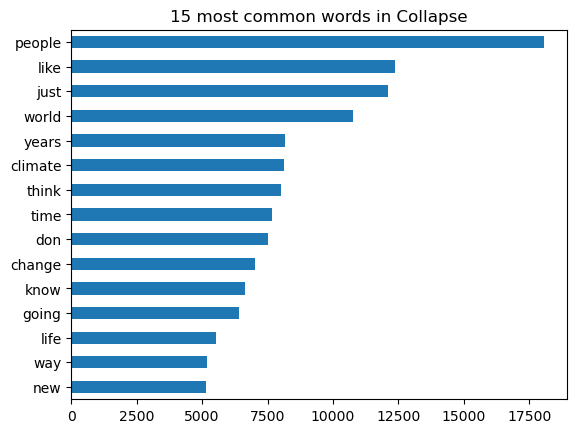

In [47]:
# most common words
collapse_cv.sum().sort_values(ascending=True).tail(15).plot(kind='barh').set(title='15 most common words in Collapse');

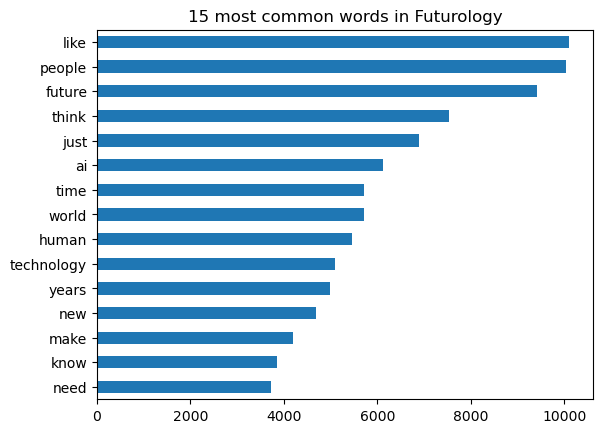

In [48]:
# most common words
futurology_cv.sum().sort_values(ascending=True).tail(15).plot(kind='barh').set(title='15 most common words in Futurology');

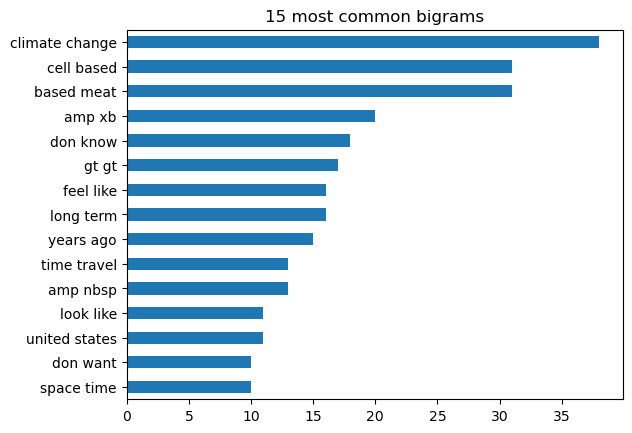

In [49]:
# most common bigrams across both
#taking a random sample of 1% of the reddit df since it's too big otherwise
cv_bi = CountVectorizer(ngram_range=(2,2), stop_words='english')
bigrams = cv_bi.fit_transform(reddit.sample(frac=0.01, random_state=1)['clean_text'])
bigrams = pd.DataFrame(bigrams.todense(), columns=cv_bi.get_feature_names_out())

bigrams.sum().sort_values(ascending=True).tail(15).plot(kind='barh').set(title='15 most common bigrams');

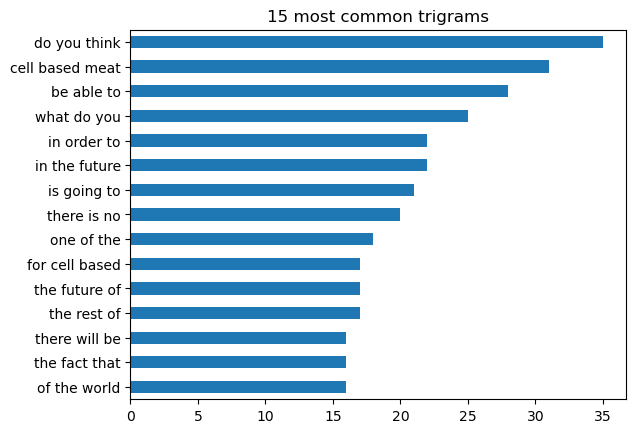

In [50]:
# most common trigrams across both
#taking a random sample of 1% of the reddit df since it's too big otherwise
#don't remove stop words because trigrams might include them
cv_tri = CountVectorizer(ngram_range=(3,3))
trigrams = cv_tri.fit_transform(reddit.sample(frac=0.01, random_state=1)['clean_text'])
trigrams = pd.DataFrame(trigrams.todense(), columns=cv_tri.get_feature_names_out())

trigrams.sum().sort_values(ascending=True).tail(15).plot(kind='barh').set(title='15 most common trigrams');

In [51]:
#save work to csv
reddit_full = reddit[['is_collapse', 'clean_text']]
reddit_full.to_csv('../data/reddit.csv', index=False)

## Sampled File

Creating a smaller file that is 10% of the original to start my modeling.  I will tune using the small file and proceed with the big file to fit my final model

In [52]:
collapse_small = collapse.sample(frac=0.1, random_state=42)
futurology_small = futurology.sample(frac=0.1, random_state=42)
reddit_small = pd.concat([collapse_small, futurology_small])

is_collapse = [1 if (each=='collapse') else 0 for each in reddit_small.subreddit]
reddit_small.insert(0, 'is_collapse', is_collapse)

reddit_small = reddit_small[['is_collapse', 'clean_text']]

reddit_small.shape

(4151, 2)

In [53]:
reddit_small.to_csv('../data/reddit_small.csv', index=False)